# Fixing the Vanishing Gradient Problem with Rectified Linear Unit (ReLU)

## Example Problem: Two Circles Binary Classification

To help investigate the problem, we study the classic binary classification problem. We use the [`make_circles()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html) function provided by `scikit-learn` to create a binary classification problem with given number of samples and statistical noise.

In [6]:
# import required libraries
from sklearn.datasets import make_circles
import numpy as np
from matplotlib import pyplot as plt

We create the dataset with $X$ denoting the input variables (coordinates in the Cartesian plane) and the label vector $y$ denoting class values in $\{0, 1\}$.

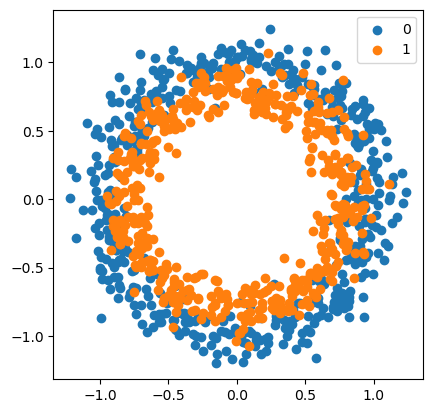

In [19]:
# generate circles
X, y = make_circles(n_samples=1000, noise=0.1, random_state=1)

for i in range(len(np.unique(y))):
    sample_indices = np.where(y == i)
    plt.scatter(X[sample_indices, 0], X[sample_indices, 1], label=str(i))
plt.legend()
plt.axis('square');